In [1]:
# import necessary packages
import numpy as np
import pandas
import matplotlib.pyplot as plt
from types import SimpleNamespace
import scipy.integrate
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

#set latex in matplotlib texts
#plt.rcParams['text.usetex'] = True

## Coding Notch interactions 

- trans-interactions, for now no cis-interactions
- based on Matlab code from https://github.com/dsprinzak/Lateral_inhibition

1D system of cells, the equations used are: 

\begin{equation}
    \frac{d d_i}{dt} = \nu (\frac{\beta_d}{1 + r_i^h} - d_i)
\end{equation}

\begin{equation}
    \frac{d r_i}{dt} = (\frac{\beta_r <d_i>^m}{1 + <d_i>^m} - r_i)
\end{equation}

with: 

\begin{equation}
    <d_i>^m = \frac{1}{w} \sum_{j \in nn(i)}d_j
\end{equation}

For all details of model see: https://link.springer.com/protocol/10.1007/978-1-4939-1139-4_22

In [3]:
def defaultparams():
    '''Defines default parameters of the system
    
    Output: 
    params : SimpleNamespace
    '''
    params = SimpleNamespace()

    # set values for the system 
    params.nu=1         	#ratio of degradation rates
    params.betaD=50         #normalized Delta production
    params.betaR=50         #normalized repressor production
    params.h=3              #Hill coefficient repression function
    params.m=3              #Hill coefficient activating function
    params.sigma=0.2        #noise amplitude in initial conditions
    params.P=18             #number of cells per column
    params.Q=18             #number of columns - MUST BE EVEN

    return params

def connectivitymatrix(P,Q):
    '''Calculates the connectivity matrix '''
    k = P*Q                 # number of cells 
    M = np.zeros([k,k])     # connectivity matrix
    w = 1/2                 # weight of interactions

    # calculating the connectivity matrix
    for i in range(k):
        i_neighbour = findneigbours(i, P, Q)
        for j in range(int(1/w)):
            M[i, i_neighbour[j]] = w 
    
    return M

def findneigbours(index, P, Q):
    '''Finds neighbours of cell with index for system of P, Q cells'''

    # finding neighbours for line of cells with periodic boundary conditions
    left = (index - 1) % P
    right = (index + 1) % P
    
    return left, right

def getIC(params, k):
    '''Get initial conditions for the system with noise term'''

    U = np.random.uniform(0,1,k) - 1/2                              #a uniform random distribution
    epsilon = 1e-5                                                  #multiplicative factor of Delta initial condition
    D0 = epsilon*params.betaD*(1 + params.sigma*U)                  #initial Delta levels 
    R0 = np.zeros(k)                                                #initial repressor levels

    initial = np.append(D0, R0)                                     #matrix of initial conditions                                          
    
    return initial

def reactions(t, y, params):
    D = y[:params.k]                                                      #levels of Delta in cells 1 to k
    R = y[params.k:]                                                      #levels of Repressor in cells 1 to k
    D_neighbours = np.sum(params.connectivity * D, axis = 1)                                #average Delta level in the neighboring cells

    #differential equations for Delta and repressor levels
    dD = params.nu * (params.betaD * 1/(1 + R**params.h) - D) 
    dR = params.betaR * D_neighbours**params.m/(1 + D_neighbours**params.m) - R
    dy = np.append(dD, dR)
    
    return dy

def animate_line(data1, data2, interval=1, plot_save=False, filename='Animation_grid.gif'):
    """
    Create a 2D animation of a grid from a 3D array.
    
    Parameters:
    - data: 3D numpy array of shape (grid_size, grid_size, num_tsteps)
    - interval: Time between frames in milliseconds
    
    Returns:
    - HTML object to display in Jupyter Notebook
    """

    grid_size = data1.shape[0]
    num_tsteps = data1.shape[1]

    R_valmax = np.ceil(np.max(R_solutions))
    R_valmin = np.min(R_solutions)

    D_valmax = np.ceil(np.max(D_solutions))
    D_valmin = np.min(D_solutions)

    # Set up the figure and two axes for vertically stacked images
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4), constrained_layout=True)

    # Plot the first image
    im1 = ax1.imshow(data1[:, 0].reshape(1,-1), cmap='YlOrRd', aspect='equal', vmin = R_valmin, vmax = R_valmax)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title('R values')

    # Add colorbar for the first image
    cbar1 = fig.colorbar(im1, ax=ax1, orientation='horizontal', fraction=0.1, pad=0.2)
    cbar1.set_label('R values')

    # Plot the second image
    im2 = ax2.imshow(data2[:, 0].reshape(1,-1), cmap='YlOrRd', aspect='equal', vmin = D_valmin, vmax = D_valmax)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_title('D values')

    # Add colorbar for the second image
    cbar2 = fig.colorbar(im2, ax=ax2, orientation='horizontal', fraction=0.1, pad=0.2)
    cbar2.set_label('D values')

    # Update function for animation
    def update(frame):
        im1.set_array(data1[:, frame].reshape(1,-1))
        im2.set_array(data2[:, frame].reshape(1,-1))
        return [im1, im2]

    # Create the animation
    ani = FuncAnimation(
        fig, update, frames=num_tsteps, interval=interval, blit=True)
    if plot_save:
        ani.save(filename, writer='imagemagick', fps=10)
        
    # Convert animation to HTML for Jupyter Notebook
    return HTML(ani.to_jshtml())



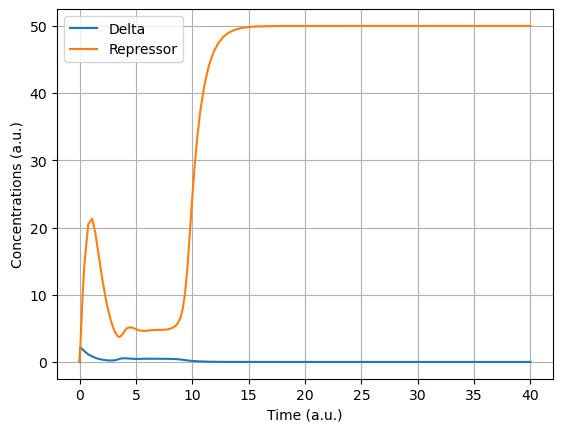

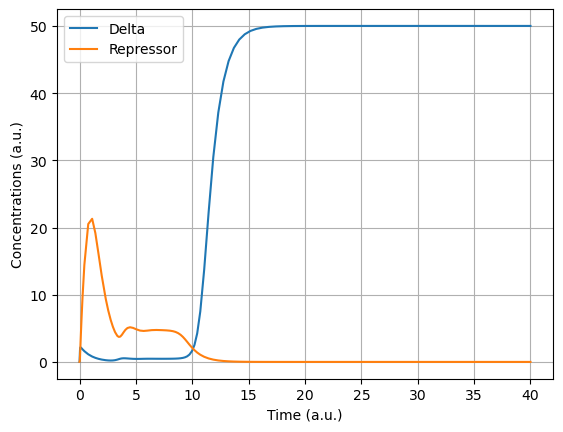

In [4]:
# get parameters of system
params = defaultparams()

# define time of simulation
time_end = 40
t_span = [0, time_end]

#for a 1D line of cells we redefine P and Q parameters
params.P = 20               # P = 2 is for a two-cell case
params.Q = 1
params.k = params.P*params.Q # total number of cells 

# get the connectivity matrix
params.connectivity = connectivitymatrix(params.P, params.Q)

# set initial conditions + some noise
initial = getIC(params, params.k)

# run simulation using ODE solver 
sol = scipy.integrate.solve_ivp(reactions, t_span, initial, method = 'RK23', args = (params, ))  

time_solution = sol.t
D_solutions = sol.y[:params.k,:]
R_solutions = sol.y[params.k:,:]

#plot solution
plt.figure()
plt.plot(time_solution,D_solutions[2,:], label='Delta')
plt.plot(time_solution, R_solutions[2,:], label = 'Repressor')
plt.xlabel('Time (a.u.)')
plt.ylabel('Concentrations (a.u.)')
plt.legend()
plt.grid()

plt.figure()
plt.plot(time_solution,D_solutions[3,:], label='Delta')
plt.plot(time_solution, R_solutions[3,:], label = 'Repressor')
plt.xlabel('Time (a.u.)')
plt.ylabel('Concentrations (a.u.)')
plt.legend()
plt.grid()



## Animation of the line of cells 

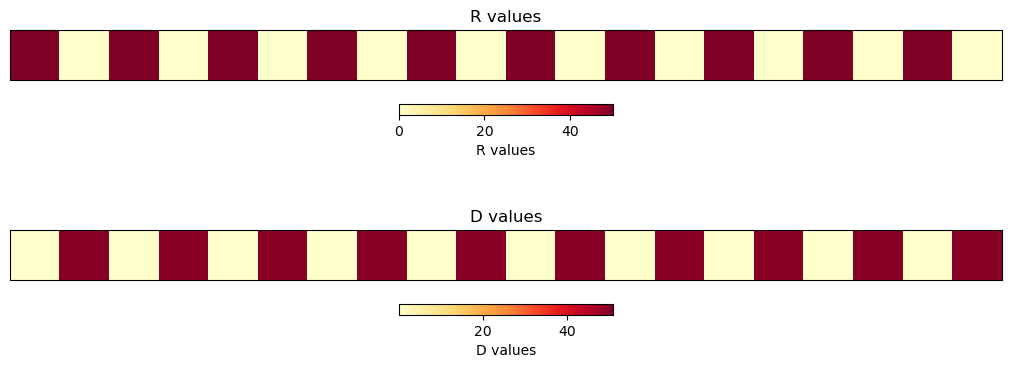

In [5]:
animate_line(R_solutions, D_solutions)

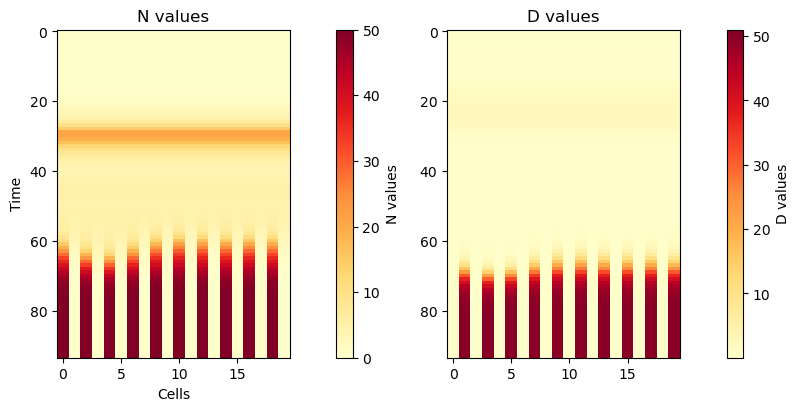

In [6]:
# Set up the figure and two axes for vertically stacked images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True)

# Plot the first image
im1 = ax1.imshow(R_solutions.T, aspect = 'auto',  cmap='YlOrRd', vmin = np.min(R_solutions), vmax = np.ceil(np.max(R_solutions)))
ax1.set_ylabel('Time')
ax1.set_xlabel('Cells')
ax1.set_title('N values')

# Add colorbar for the first image
cbar1 = fig.colorbar(im1, ax=ax1, orientation='vertical', fraction=0.1, pad=0.2)
cbar1.set_label('N values')

# Plot the second image
im2 = ax2.imshow(D_solutions.T, aspect = 'auto',  cmap='YlOrRd', vmin = np.min(D_solutions), vmax = np.ceil(np.max(D_solutions)))
ax2.set_title('D values')

# Add colorbar for the second image
cbar2 = fig.colorbar(im2, ax=ax2, orientation='vertical', fraction=0.1, pad=0.2)
cbar2.set_label('D values')